Loading trip data...
Loading zone lookup...
Calculating average fare per zone...


C:\Users\dhruv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\dask\dataframe\multi.py:169: UserWarning: Merging dataframes with merge column data type mismatches: 
+------------------------------+------------+-------------+
| Merge columns                | left dtype | right dtype |
+------------------------------+------------+-------------+
| ('LocationID', 'LocationID') | int32      | int64       |
+------------------------------+------------+-------------+
Cast dtypes explicitly to avoid unexpected results.
  warnings.warn(



Top 10 Pickup Zones by Average Fare:

Zone
Arden Heights                          96.670000
Newark Airport                         89.393506
Rikers Island                          84.470000
Rossville/Woodrow                      81.886667
JFK Airport                            80.925104
Outside of NYC                         80.625508
Flushing Meadows-Corona Park           79.400040
LaGuardia Airport                      76.808987
Mariners Harbor                        75.323333
Breezy Point/Fort Tilden/Riis Beach    67.630000
Name: total_amount, dtype: float64


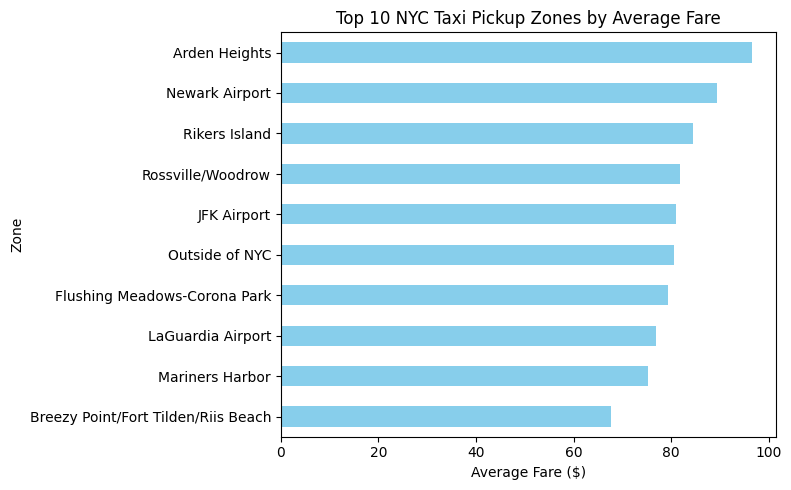

In [3]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import os

# === File paths (UPDATE these if your files are in a different folder) ===
trip_data_path = "C:/Users/dhruv/Downloads/yellow_tripdata_2025-01.parquet"
zone_lookup_path = "C:/Users/dhruv/Downloads/taxi_zone_lookup.csv"

# === Check if files exist before loading ===
if not os.path.exists(trip_data_path):
    raise FileNotFoundError(f"Trip data file not found at: {trip_data_path}")

if not os.path.exists(zone_lookup_path):
    raise FileNotFoundError(f"Zone lookup file not found at: {zone_lookup_path}")

# === Load the main taxi trip data (Parquet is great for large datasets) ===
print("Loading trip data...")
trip_df = dd.read_parquet(trip_data_path)

# === Load zone lookup CSV (to map LocationID to Zone names) ===
print("Loading zone lookup...")
zone_df = dd.read_csv(zone_lookup_path)

# === Prepare for join: rename column to match ===
trip_df = trip_df.rename(columns={"PULocationID": "LocationID"})

# === Join trip data with zone names on pickup LocationID ===
merged_df = trip_df.merge(zone_df, on="LocationID", how="left")

# === Filter out invalid or missing data ===
clean_df = merged_df.dropna(subset=[
    "trip_distance", "total_amount",
    "tpep_pickup_datetime", "tpep_dropoff_datetime"
])
clean_df = clean_df[(clean_df["trip_distance"] > 0) & (clean_df["total_amount"] > 0)]

# === Convert datetime columns ===
clean_df["tpep_pickup_datetime"] = dd.to_datetime(clean_df["tpep_pickup_datetime"])
clean_df["tpep_dropoff_datetime"] = dd.to_datetime(clean_df["tpep_dropoff_datetime"])

# === Calculate trip duration in minutes ===
clean_df["trip_duration_min"] = (
    (clean_df["tpep_dropoff_datetime"] - clean_df["tpep_pickup_datetime"]).dt.total_seconds() / 60
)

# === Compute average fare by pickup zone ===
print("Calculating average fare per zone...")
avg_fare_by_zone = clean_df.groupby("Zone")["total_amount"].mean().compute()
avg_fare_by_zone = avg_fare_by_zone.sort_values(ascending=False)

# === Display top 10 zones ===
print("\nTop 10 Pickup Zones by Average Fare:\n")
print(avg_fare_by_zone.head(10))

# === Optional: Plot the top 10 zones ===
avg_fare_by_zone.head(10).plot(kind="barh", figsize=(8, 5), color="skyblue")
plt.xlabel("Average Fare ($)")
plt.title("Top 10 NYC Taxi Pickup Zones by Average Fare")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
